In [54]:
# data
from sklearn.datasets import fetch_mldata
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# model validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

# visualisation
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Getting the data 
mnist = fetch_mldata('MNIST original')

# Split into data and labels
X, y = mnist['data'], mnist['target']

# shuffling the data 
shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]

# splitting the data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

/Users/kamilwyszynski/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kamilwyszynski/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
# Now, we're going to use the SGD model to classify all 10 numbers at once.
# As the SGD classifier is a linear classifier, scikit learn will know to perform
# a OvA (one-versus-all) strategy.
# That menas that it will train one SGD model to classify each number separately

sgd_class = SGDClassifier(random_state=42)
sgd_class.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Predicted: [0.]


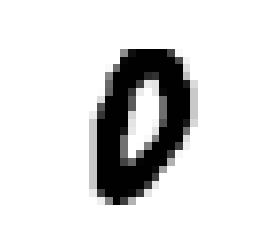

In [43]:
# Verifying the prediction by passing a random number image

def prediction_print(model):
    rand = random.randint(0, 10000)
    X_example = X_train[rand]
    y_example = y_train[rand]

    %matplotlib inline
    plt.imshow(X_example.reshape(28,28), cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis('off')

    # score_example = sgd_class.decision_function([X_example])
    prediction_example = model.predict([X_example])

    print(f'Predicted: {prediction_example}')

prediction_print(sgd_class)

In [40]:
# We can also train the Random Forest model.
# This time no OvA/OvO will be needed as the model itself is capable of multinomial classification

forest_class = RandomForestClassifier(random_state=42)
forest_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Predicted: [2.]


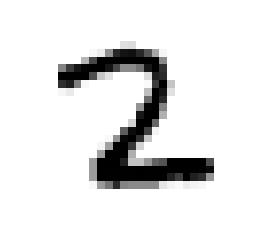

In [48]:
# Visualising thge prediction

prediction_print(forest_class)

In [51]:
# We can additionally see the list of probabilities of the rf model

# In this case the model is 100% sure that the digit ion the picture is a 7
forest_class.predict_proba([X_train[36000]])

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

## Model Validations

In [52]:
# Evaluating the SDG model by cross validation with accuracy as the score
sdg_accuracy = cross_val_score(sgd_class, X_train, y_train, cv=3, scoring='accuracy')

[0.86731327 0.8804     0.88283828]


In [55]:
# Evaluating the SDG model using standardised trauining data.
# This will most likely improve the accuracy score of the model as all the features of 
# each datapoint will be standardised

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_class, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.89986001, 0.9066    , 0.89943994])

## Error analysis

In [56]:
# In order to detect the flaws of the system, we could look at the confusion matrix
# and verify where the model is making the most mistakes
y_train_pred = cross_val_predict(sgd_class, X_train_scaled, y_train)
sdg_conf_mtx = confusion_matrix(y_train, y_train_pred)

sdg_conf_mtx

array([[5629,    0,   18,    8,    7,   43,   36,    7,  213,    1],
       [   0, 6403,   35,   20,    4,   43,   10,    8,  178,   13],
       [  25,   28, 5256,   84,   74,   25,   69,   39,  362,   12],
       [  26,   19,  117, 5215,    1,  190,   26,   32,  376,   69],
       [   8,   12,   40,   11, 5235,    9,   38,   23,  290,  163],
       [  30,   13,   25,  160,   59, 4476,   89,   20,  479,   66],
       [  29,   20,   51,    2,   41,   90, 5572,    9,  132,    0],
       [  25,    9,   61,   27,   43,    9,    4, 5681,  153,  225],
       [  15,   49,   48,   88,    5,  122,   27,    6, 5435,   49],
       [  24,   21,   25,   61,  122,   35,    1,  178,  323, 5216]])

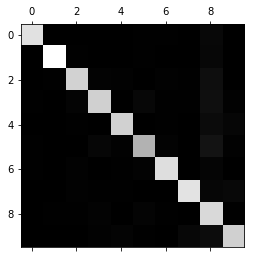

In [57]:
# It's more visible on a graph showing the scale of the confusion.
# Each row represents a class and each column represents the prediction.

plt.matshow(sdg_conf_mtx, cmap=plt.cm.gray)
plt.show()

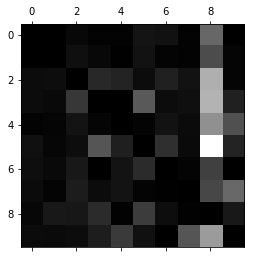

In [62]:
# In order to get a more normalised view of the matrix, we can devide each row
# by the number of datapoints in that class.
cat_sums = sdg_conf_mtx.sum(axis=1, keepdims=True)
norm_sdg_conf_mtx = sdg_conf_mtx / cat_sums

# Now, lets fill the diagonal with 0's as the correct predictions do nopt concern us.
np.fill_diagonal(norm_sdg_conf_mtx, 0)

# and display
plt.matshow(norm_sdg_conf_mtx, cmap=plt.cm.gray)
plt.show()

# We can see immediatelly that nearly all of the numbers are being confused with 8's
# Most notably 0,2,3,4,5 and 9 from which 5 is very bad

In [69]:
# You can see here that 8's are not the smalles class in the dataset
np.unique(y_train, return_counts=True)[1]

array([5962, 6714, 5974, 6071, 5829, 5417, 5946, 6237, 5844, 6006])

In [ ]:
# Lastly, it would be a good idea to analise the individual errors.
# However, I'm not going to include that in this notebook